<a href="https://colab.research.google.com/github/xinhaohe245/movies-data-analysis/blob/main/tmdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install pygam
!pip install cpi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cpi
import statsmodels.formula.api as smf
from pygam import LinearGAM, GAM, s, f, te
from statsmodels.tsa.api import ExponentialSmoothing
from datetime import timedelta, date

# added: graph formatting
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
# sns.set_style("ticks")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 7.4 MB/s eta 0:00:00


In [37]:
df = pd.read_csv('movies.csv', na_values=['0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722861 entries, 0 to 722860
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    722861 non-null  int64  
 1   title                 722851 non-null  object 
 2   genres                511943 non-null  object 
 3   original_language     722861 non-null  object 
 4   overview              604234 non-null  object 
 5   popularity            722861 non-null  float64
 6   production_companies  337158 non-null  object 
 7   release_date          670317 non-null  object 
 8   budget                36580 non-null   float64
 9   revenue               16956 non-null   float64
 10  runtime               557256 non-null  float64
 11  status                722861 non-null  object 
 12  tagline               108081 non-null  object 
 13  vote_average          296205 non-null  float64
 14  vote_count            296438 non-null  float64
 15  

In [38]:
# Pre-processing
df.dropna(subset=['revenue', 'budget', 'runtime', 'release_date', 'vote_count'], inplace=True)
df.drop_duplicates(inplace=True)
df = df[(df['status'] == 'Released') &  (df['original_language'] == 'en') & (df['vote_count'] >= 15)]
df.drop(['original_language', 'status', 'poster_path', 'backdrop_path', 
         'recommendations'], axis=1, inplace=True)
# Correct misinterpreted years for pre-1970 dates
df['release_date'] =  pd.to_datetime(df['release_date'])
incorrect_dates= df['release_date'] > pd.Timestamp(year=2024,month=1,day=1)
df.loc[incorrect_dates, 'release_date'] -= timedelta(days=365.25*100)

# Adjust for inflation
def attempt_inflate(row, col):
  try:
    return cpi.inflate(row[col], row['release_date'], items='All items less food, shelter, and energy')
  except:
    return row[col]
df['adjusted_revenue'] = df.apply(lambda x : attempt_inflate(x, 'revenue'),axis=1)
df['adjusted_budget'] = df.apply(lambda x : attempt_inflate(x, 'budget'),axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6737 entries, 0 to 286220
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    6737 non-null   int64         
 1   title                 6737 non-null   object        
 2   genres                6737 non-null   object        
 3   overview              6737 non-null   object        
 4   popularity            6737 non-null   float64       
 5   production_companies  6633 non-null   object        
 6   release_date          6737 non-null   datetime64[ns]
 7   budget                6737 non-null   float64       
 8   revenue               6737 non-null   float64       
 9   runtime               6737 non-null   float64       
 10  tagline               6251 non-null   object        
 11  vote_average          6737 non-null   float64       
 12  vote_count            6737 non-null   float64       
 13  credits         

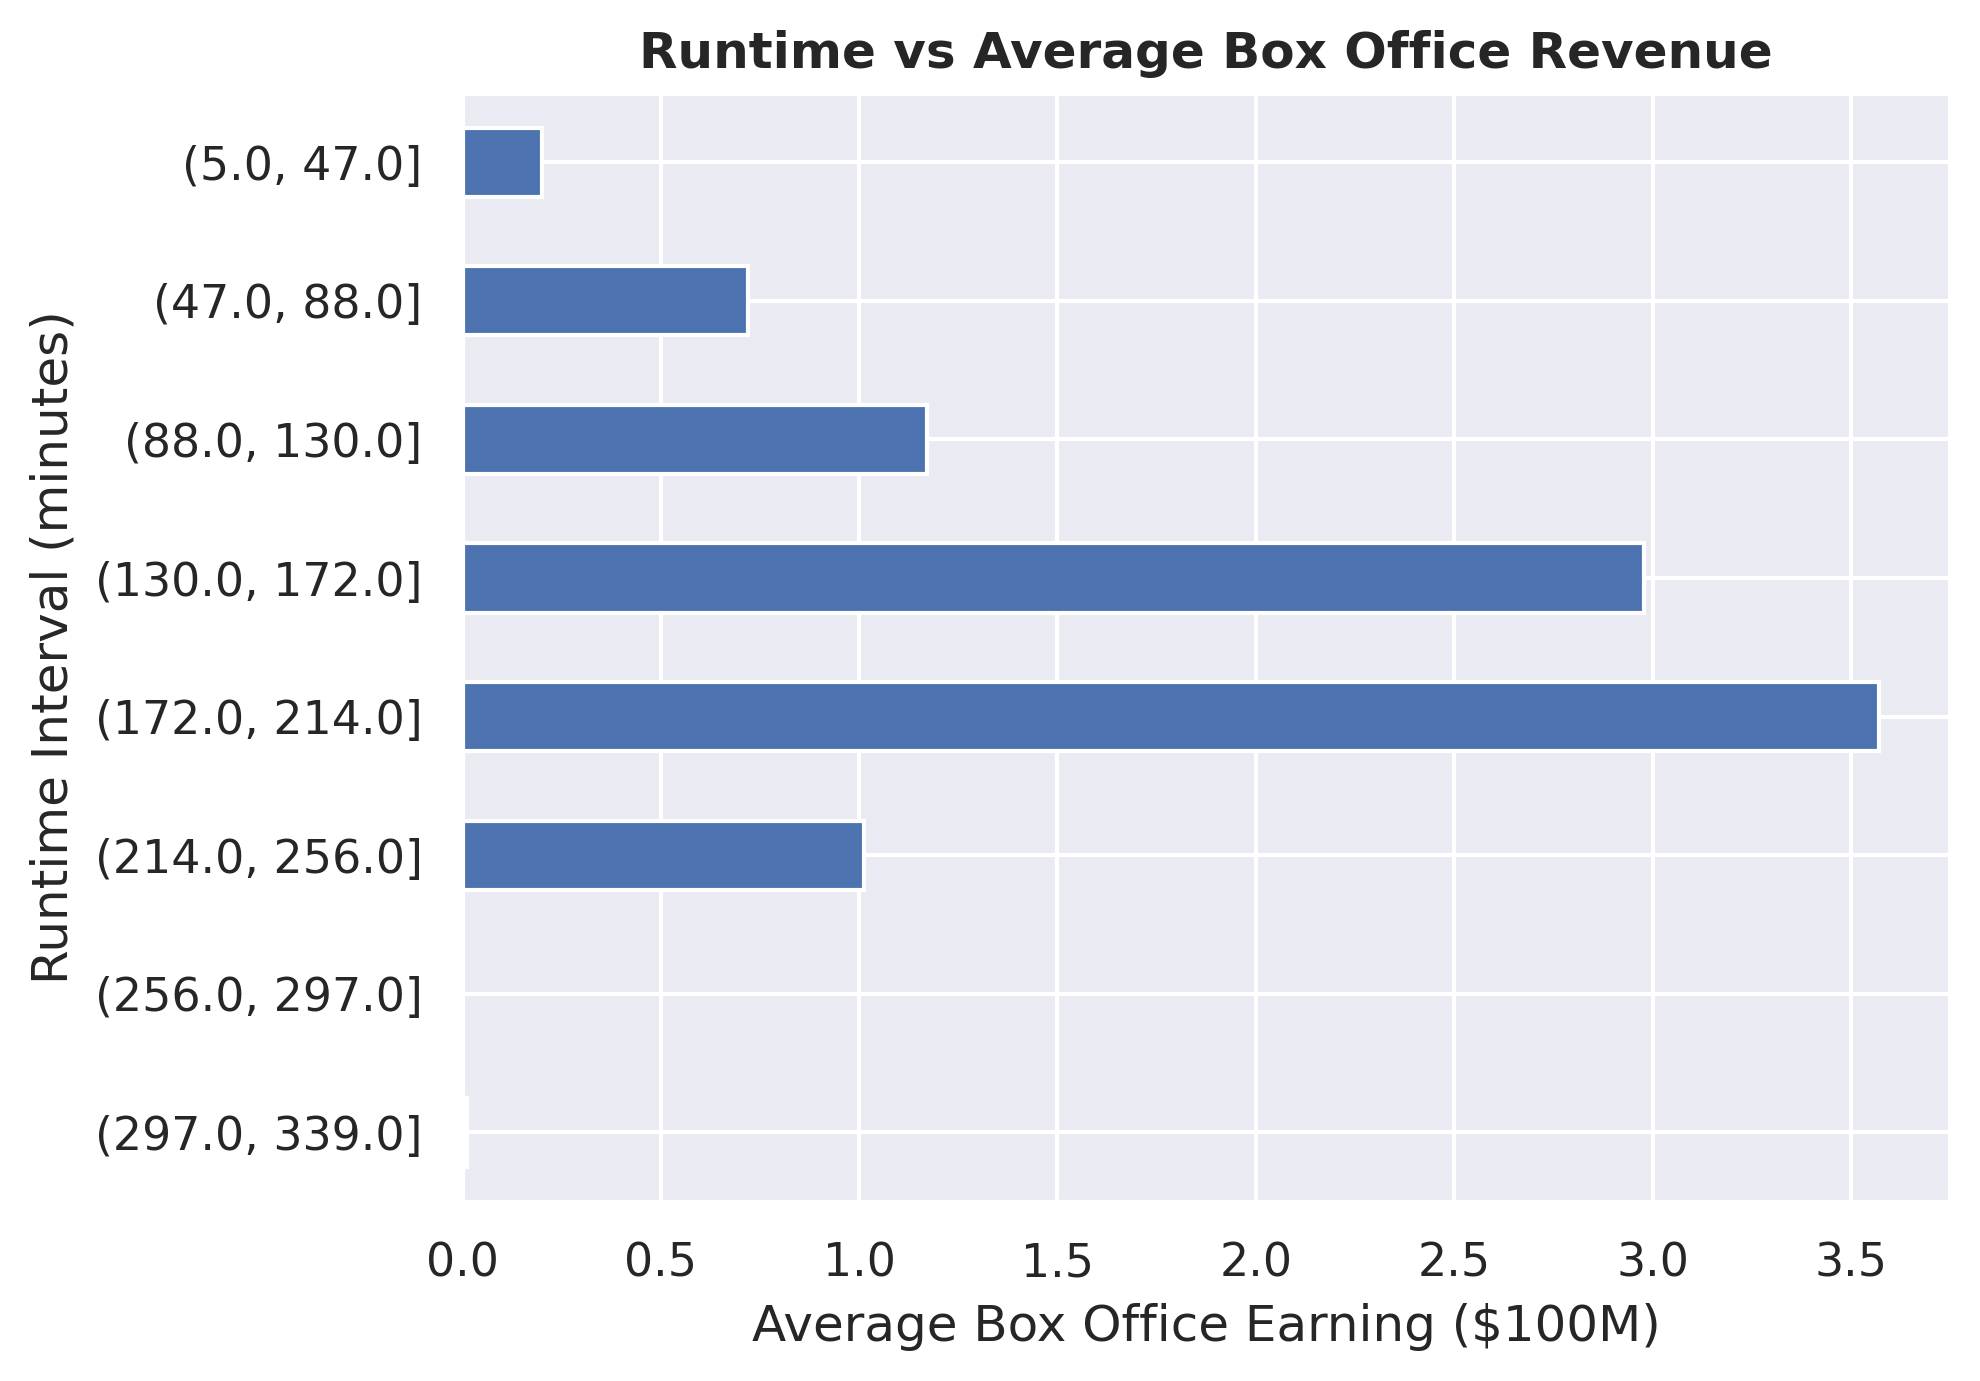

In [40]:
runtime_intervals = pd.cut(df['runtime'], 8, precision=0)
avg_box_office_per_interval = df.groupby(runtime_intervals)['adjusted_revenue'].mean()/1e8
fig = avg_box_office_per_interval.plot.barh()
plt.ylabel('Runtime Interval (minutes)')
fig.invert_yaxis()
plt.xlabel('Average Box Office Earning ($100M)')
plt.title('Runtime vs Average Box Office Revenue', weight='bold')
plt.show()

In [16]:
genres_df = df.copy()
genres_df['individual_genre'] = genres_df['genres'].str.split("-")
genres_df = genres_df.explode('individual_genre')
genres_df = genres_df[genres_df['individual_genre'] != 'TV Movie']

# # Export to csv format for Tableau analysis
# genres_df.to_csv('movie_genres.csv', index=False)

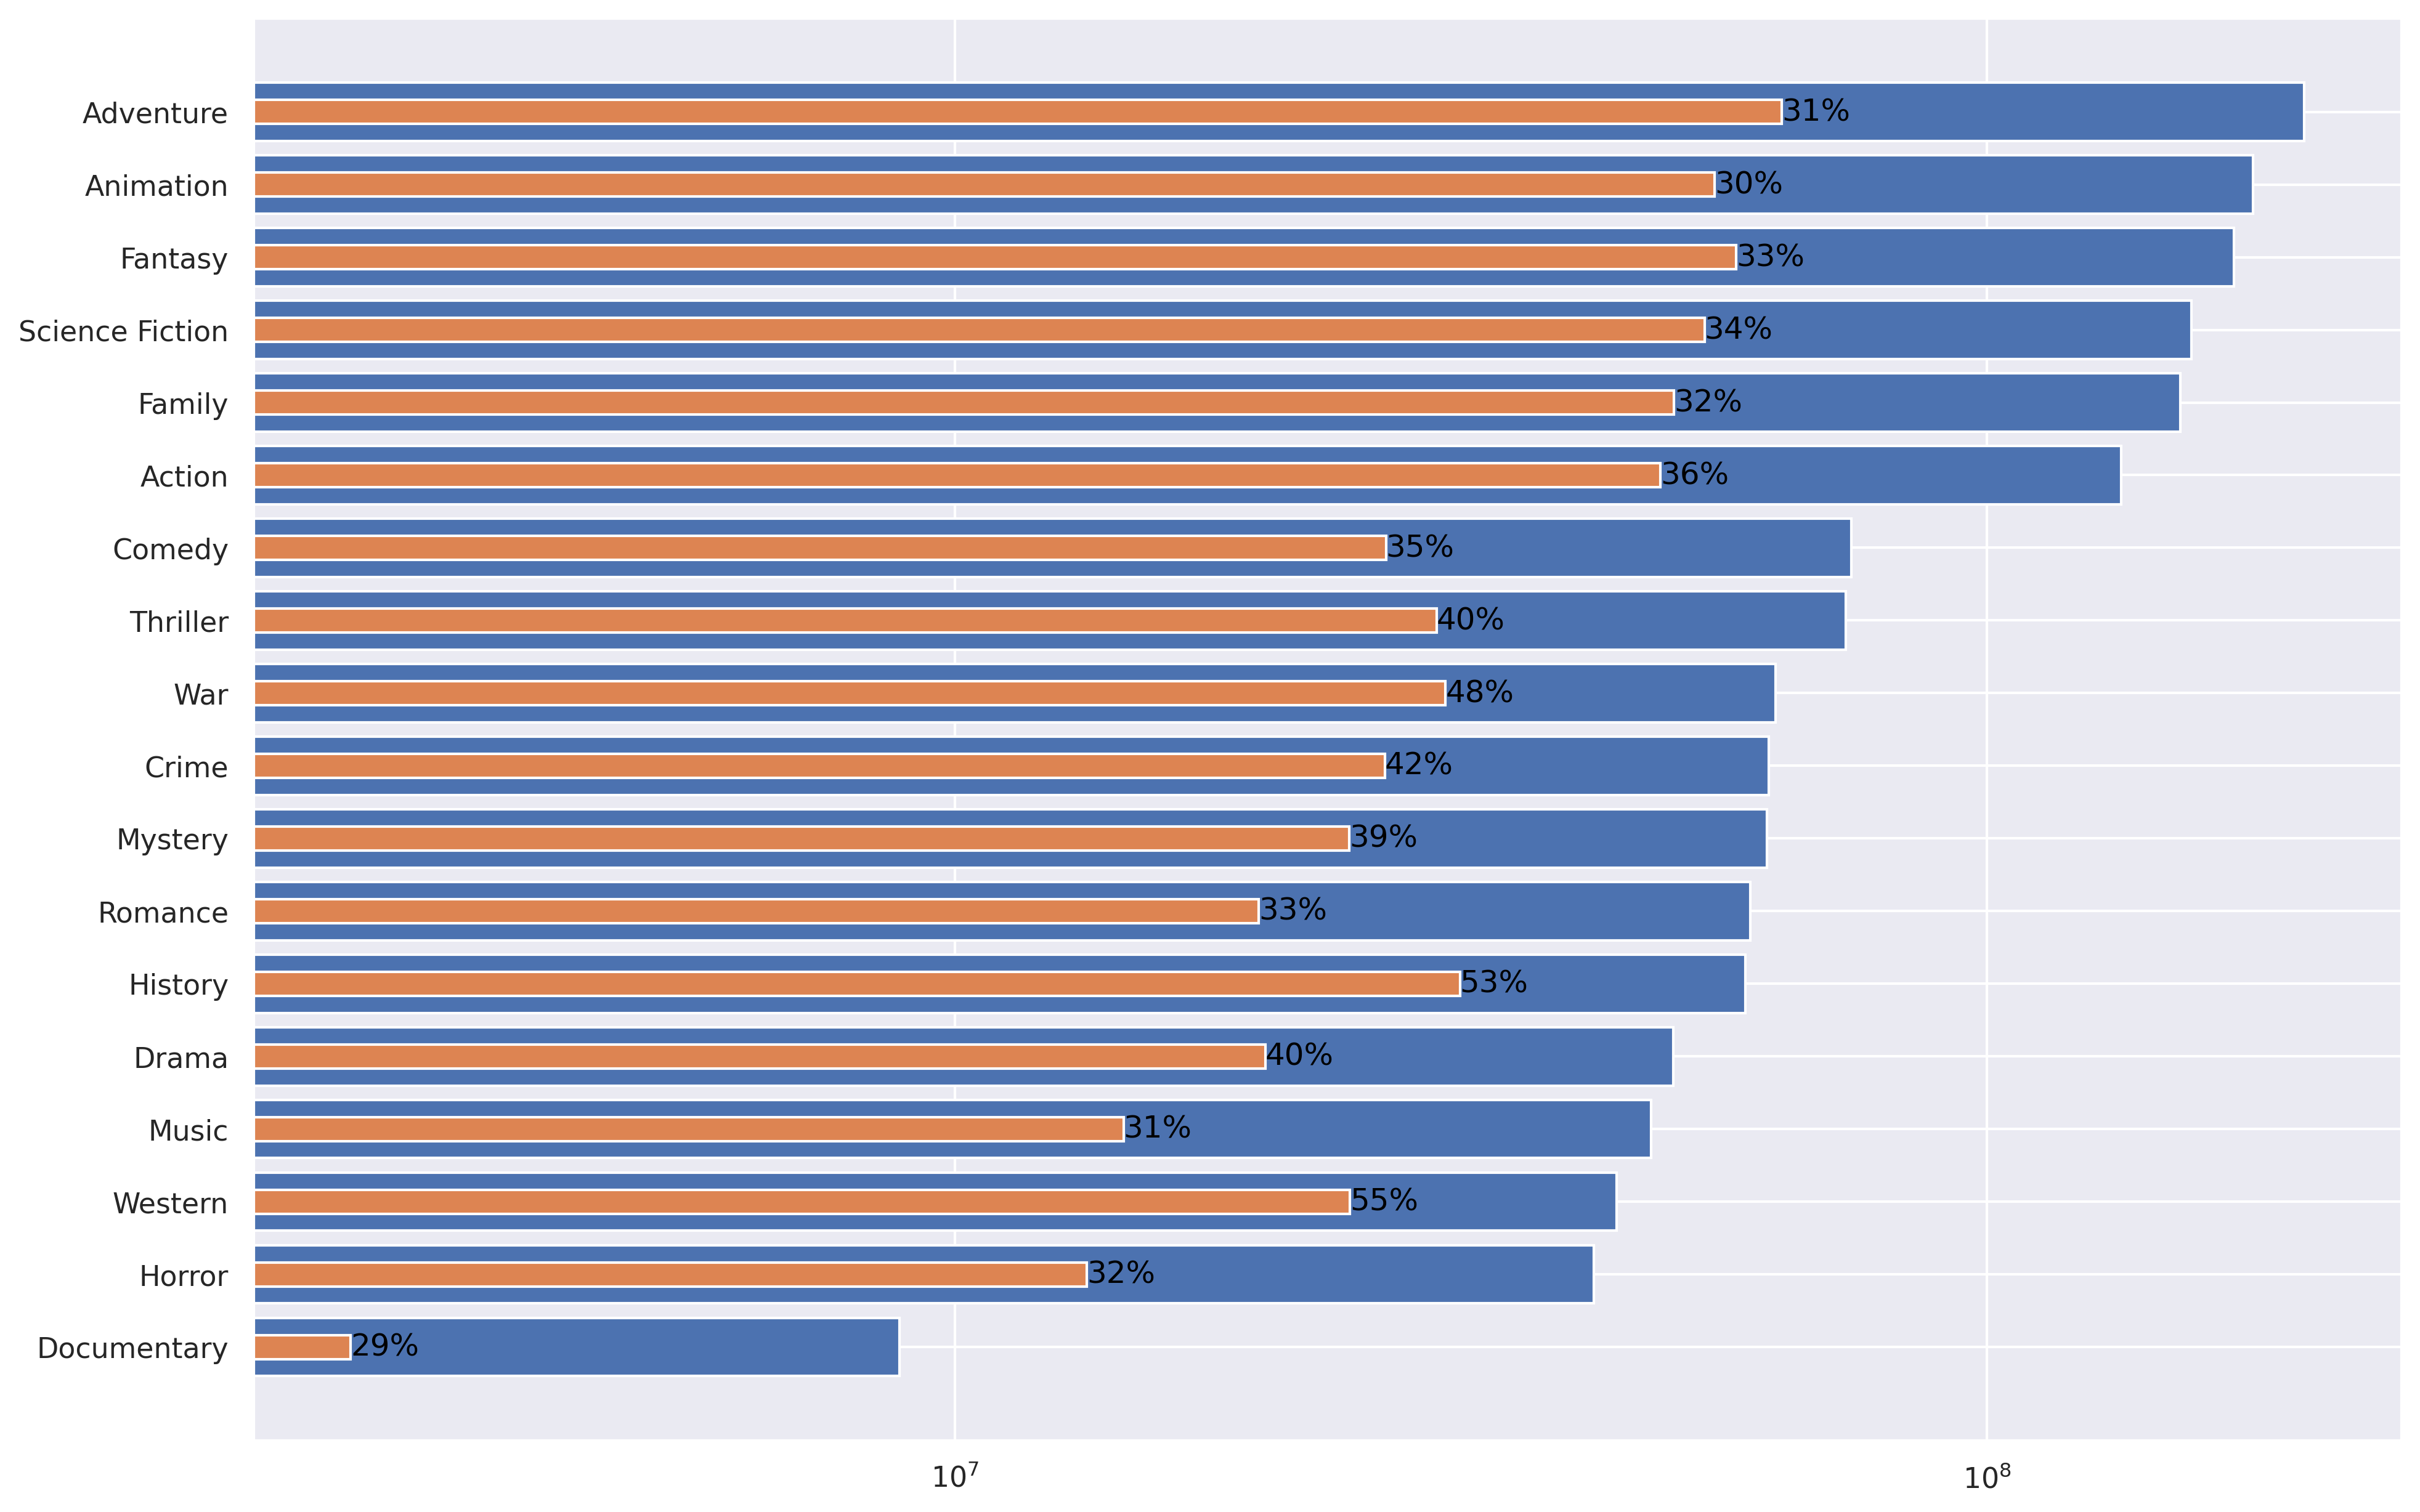

In [41]:
budget_box_office = genres_df.groupby(['individual_genre'])[['adjusted_revenue', 'adjusted_budget']].mean()
budget_box_office = budget_box_office.reset_index().sort_values('adjusted_revenue')
box_office = budget_box_office['adjusted_revenue']
budget = budget_box_office['adjusted_budget']
budget_box_office['budget_percent'] = round(budget / box_office, 2)

indices = np.arange(len(box_office))

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.barh(y=indices, width=box_office, align='center')
bar2= ax.barh(y=indices, width=budget, height = 1/3, align='center')
for i, p in enumerate(bar2.patches):
  label = '{:,.0f}%'.format(budget_box_office['budget_percent'].iloc[i] * 100)
  x_value = p.get_width()
  y_value = p.get_y() + p.get_height() / 2
  plt.annotate(label, (x_value, y_value), va='center', ha='left', color = 'black')     

plt.yticks(indices, budget_box_office['individual_genre'])
plt.xscale('log')

plt.show()

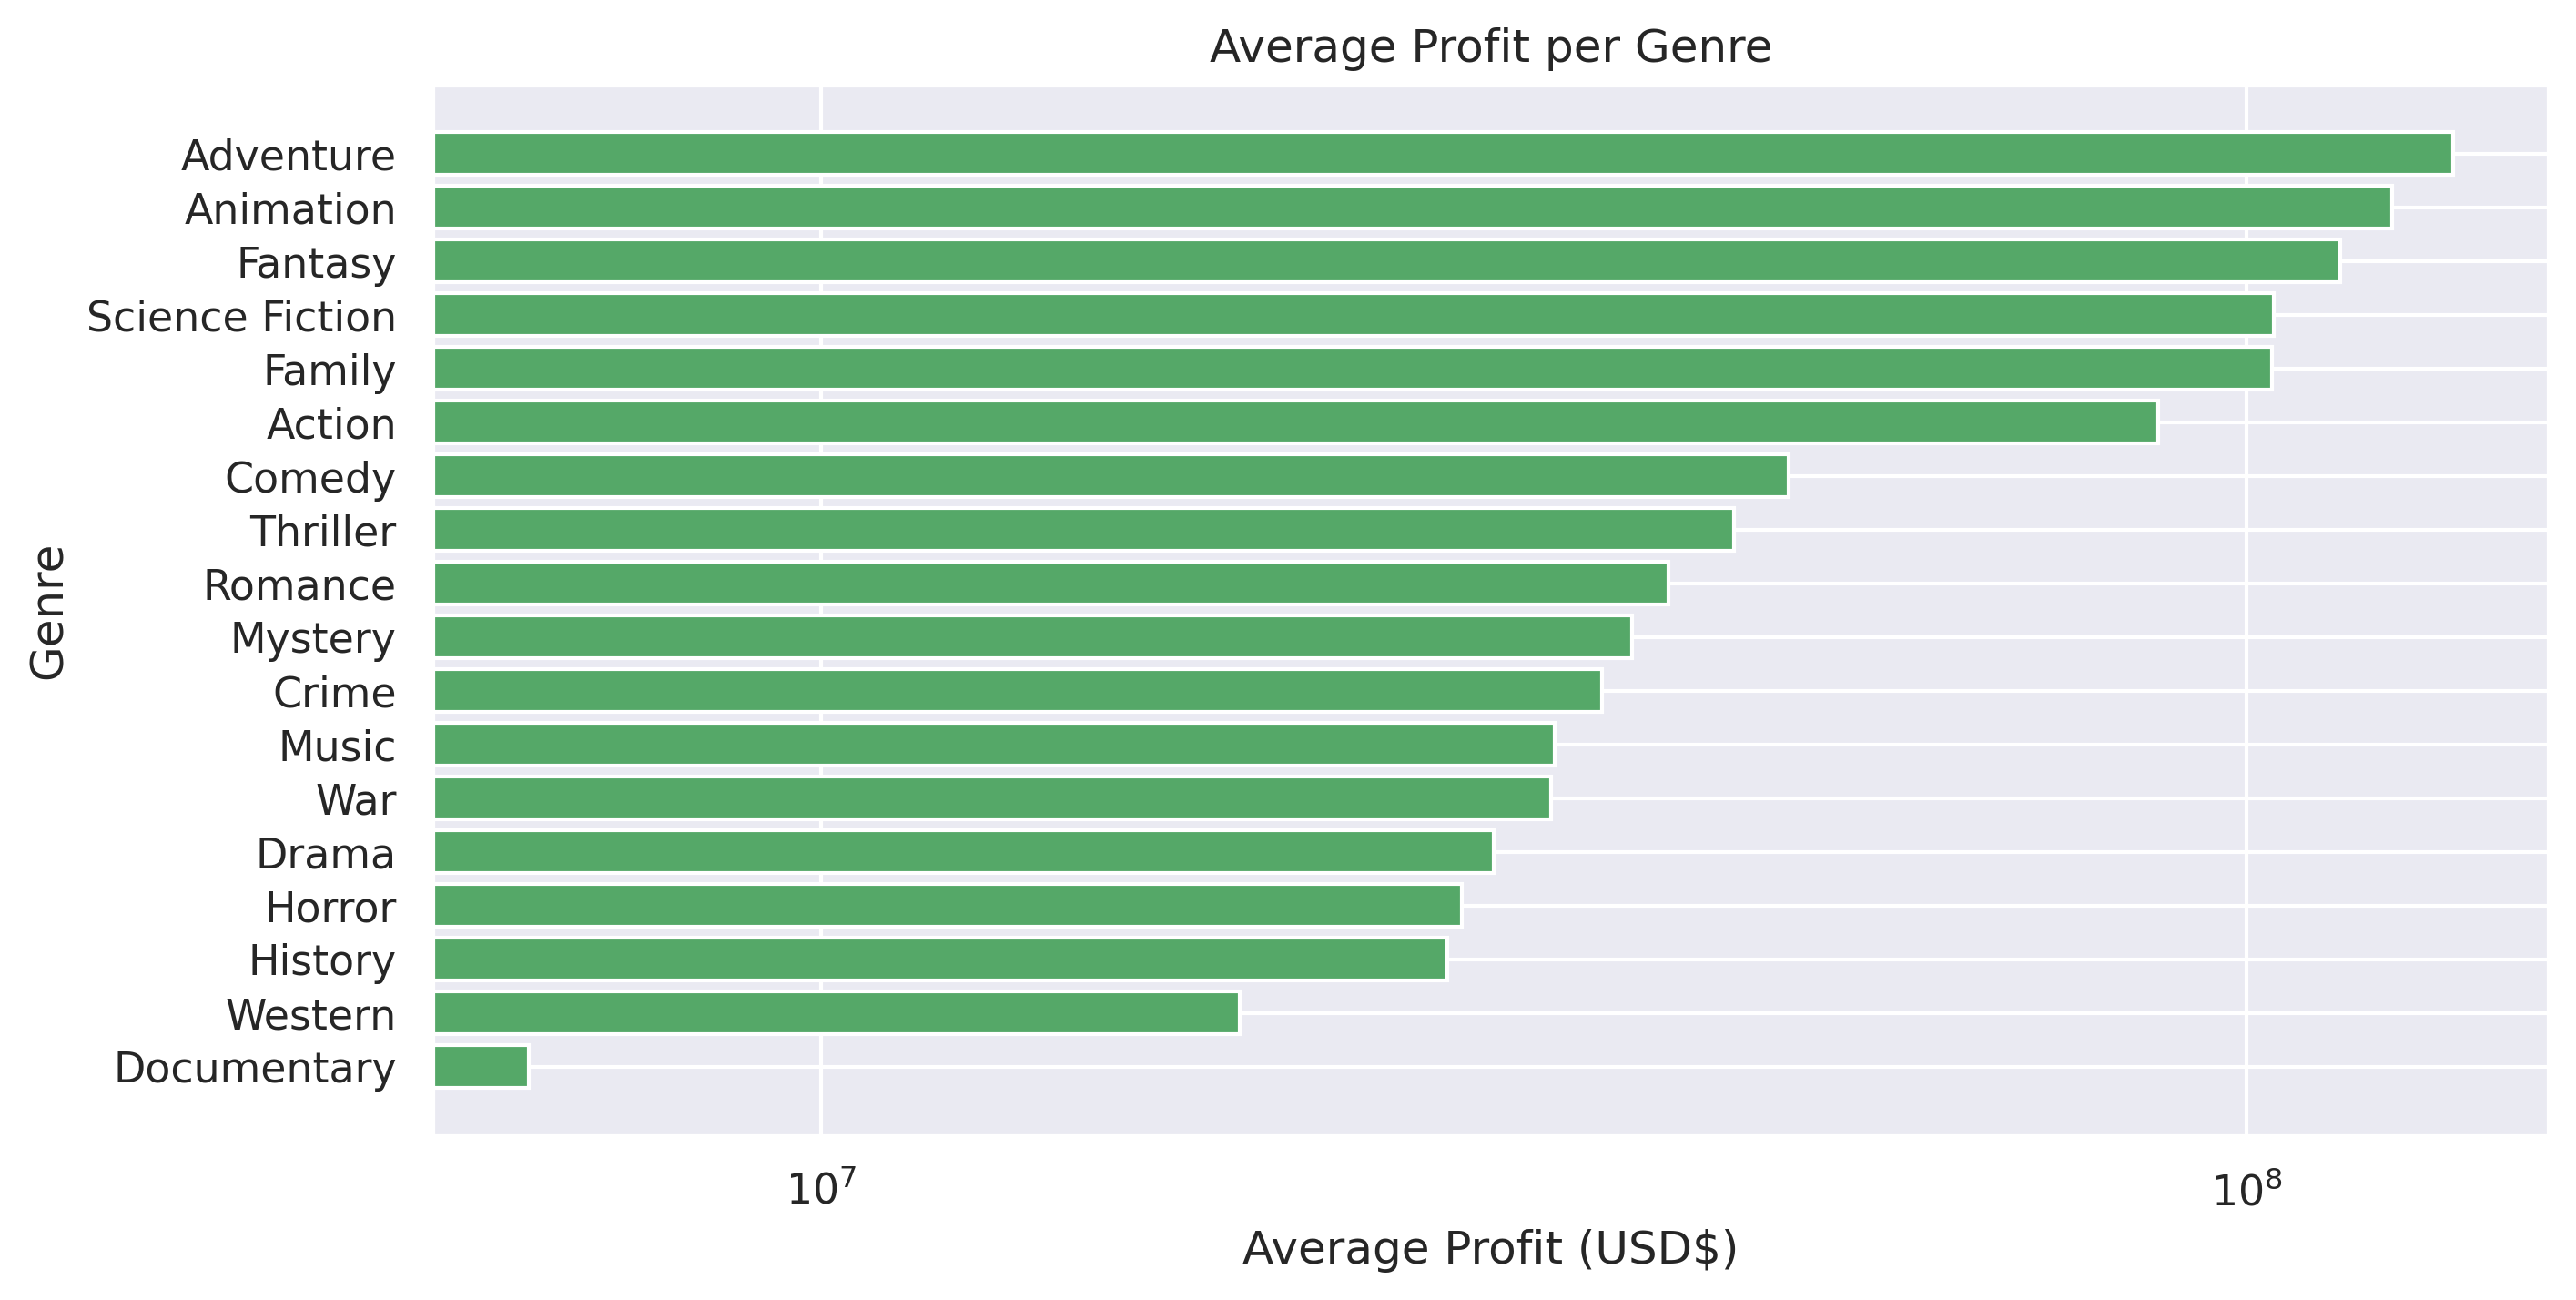

In [42]:
genres_df['profit'] = genres_df['adjusted_revenue'] - genres_df['adjusted_budget']
profit_per_genre = genres_df.groupby(['individual_genre'])['profit'].mean()
profit_per_genre = profit_per_genre.reset_index().sort_values(['profit'])
made_profit = profit_per_genre['profit'] > 0
genres_with_profit = profit_per_genre[made_profit].sort_values(['profit'])
genres_with_loss = profit_per_genre[~made_profit]
plt.figure(figsize=(10,5))
plt.barh(genres_with_profit['individual_genre'],genres_with_profit['profit'],color = 'g')
plt.barh(genres_with_loss['individual_genre'],genres_with_loss['profit'],color = 'r')
plt.xscale('log')
plt.ylabel('Genre')
plt.xlabel('Average Profit (USD$)')
plt.title('Average Profit per Genre')
plt.show()

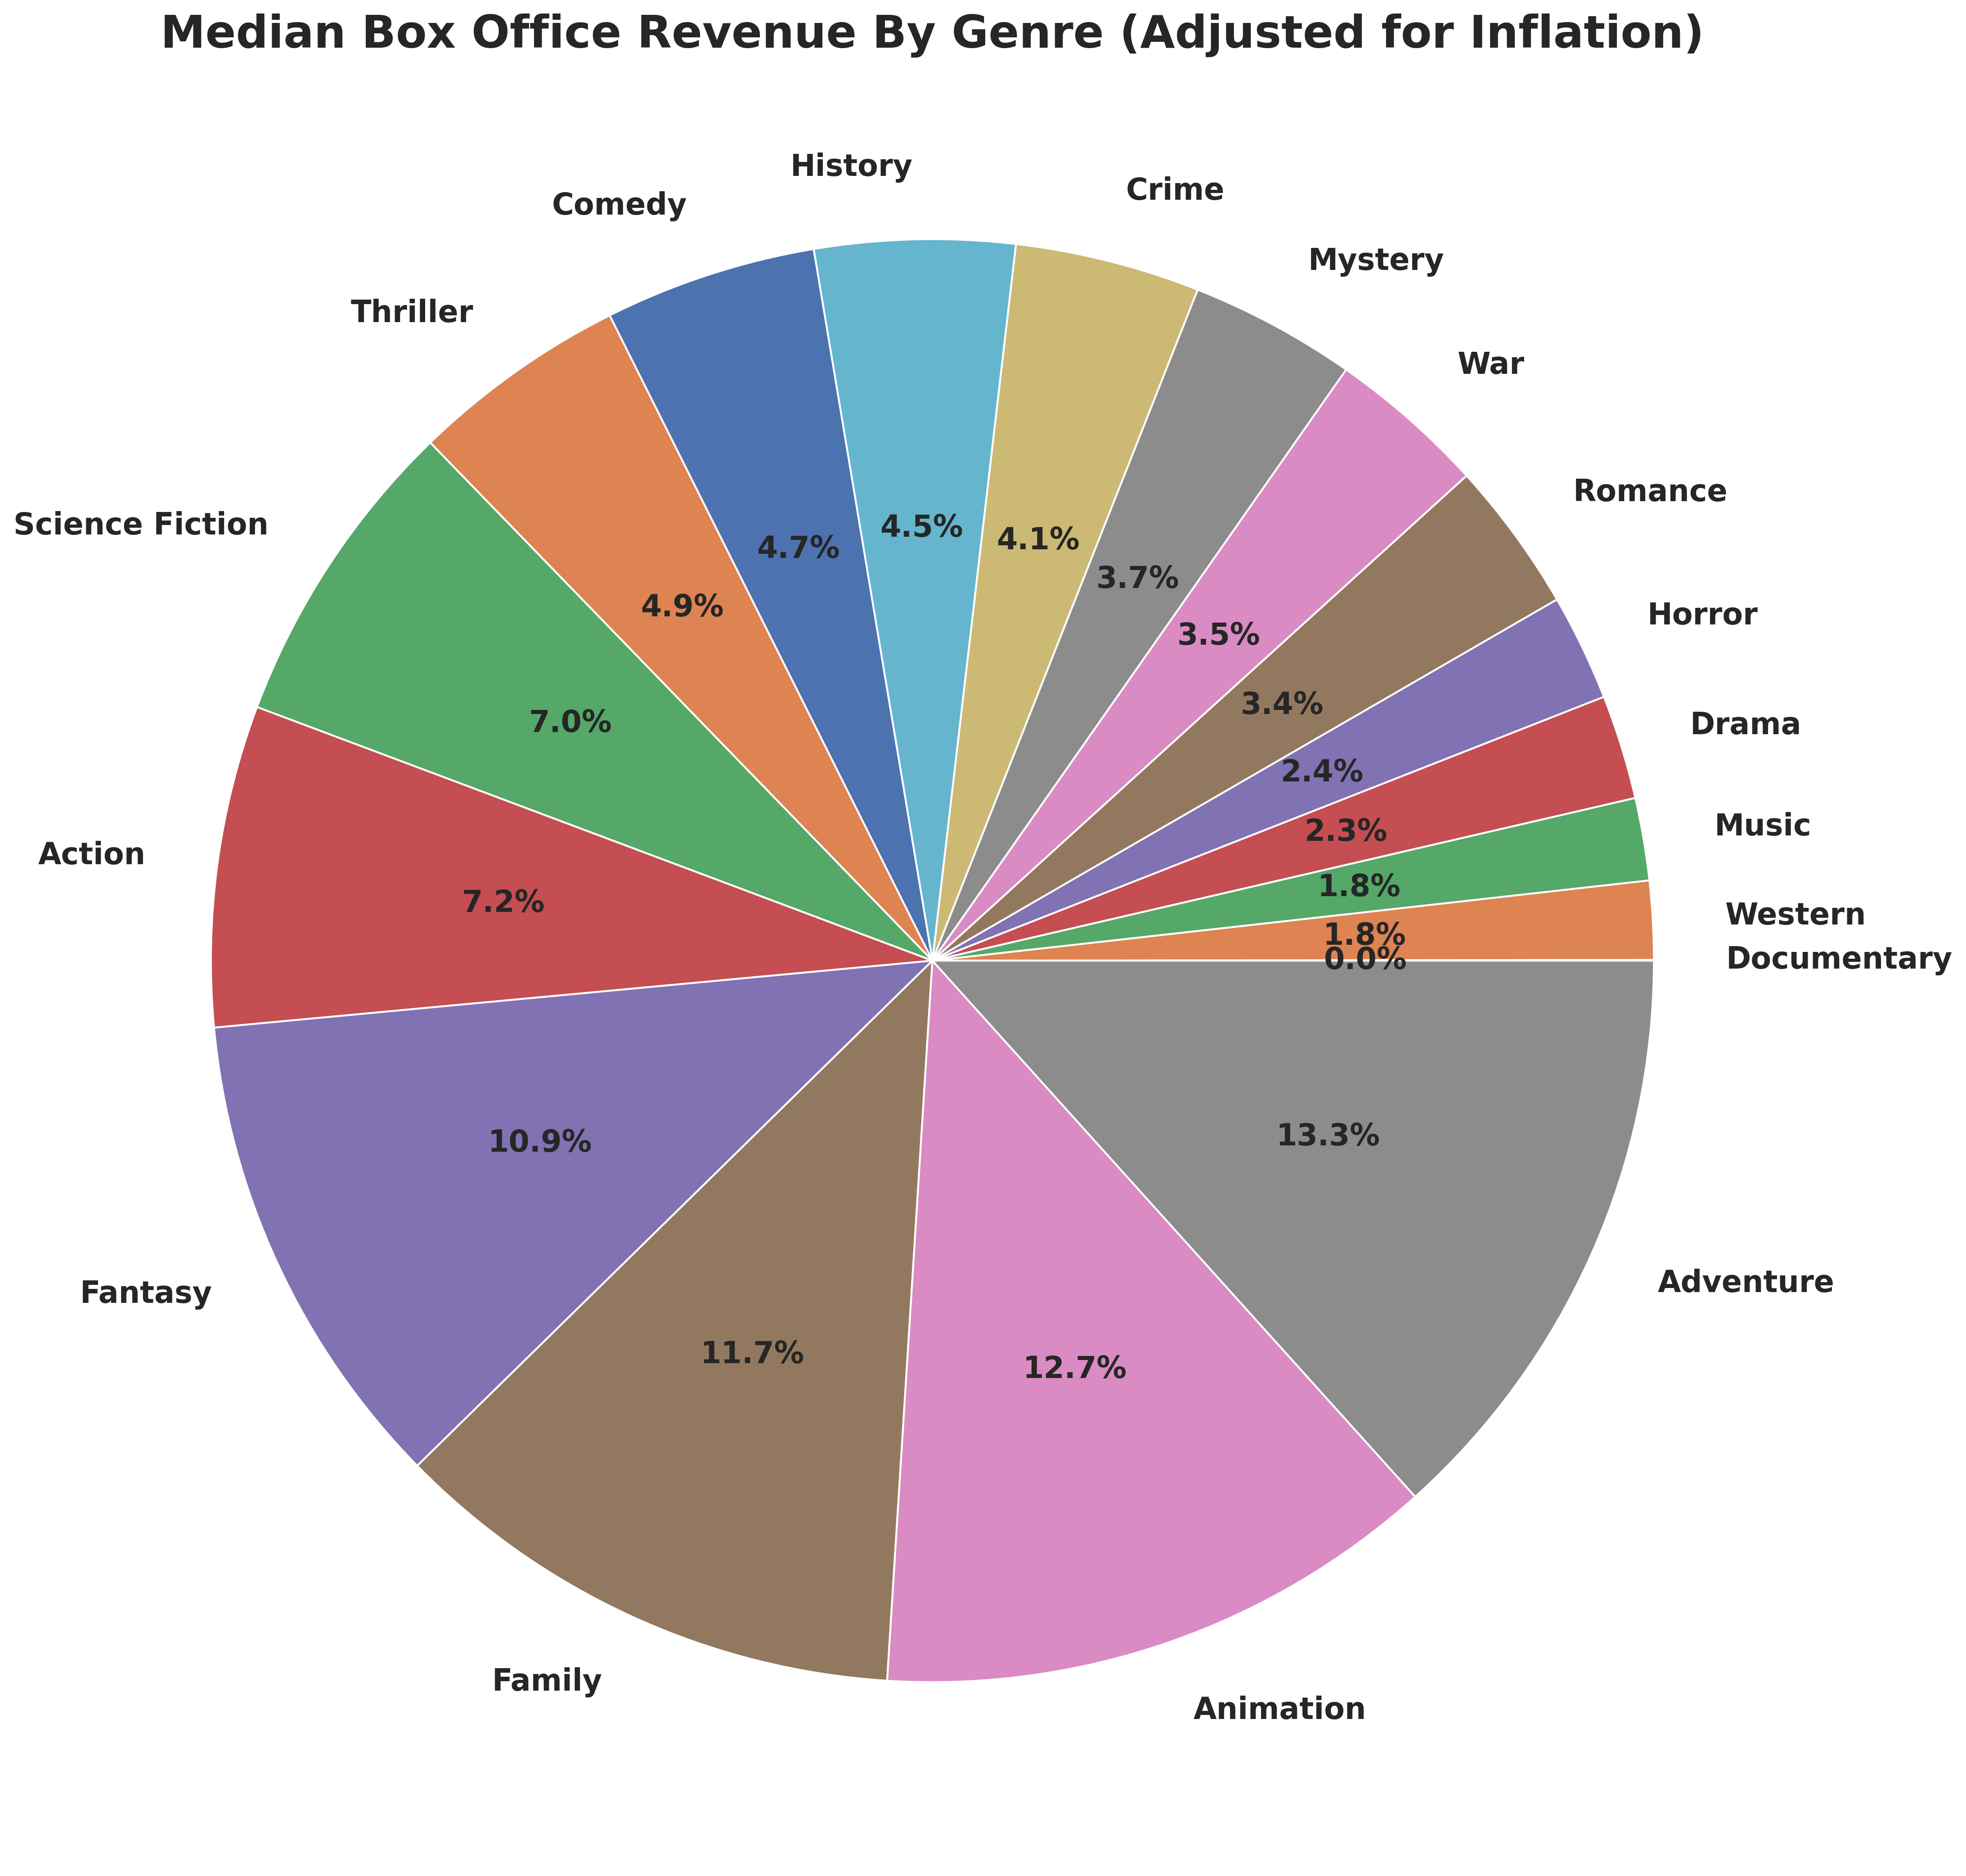

In [43]:
med_revenue_by_genre = genres_df.groupby('individual_genre')['adjusted_revenue'].median().reset_index().sort_values('adjusted_revenue')

plt.figure(figsize=(15,15))
plt.pie(med_revenue_by_genre['adjusted_revenue'], labels=med_revenue_by_genre['individual_genre'], autopct = '%1.1f%%', textprops={'weight': 'bold', 'fontsize': 16})
plt.tight_layout()
plt.title("Median Box Office Revenue By Genre (Adjusted for Inflation)", fontsize=24, weight='bold')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


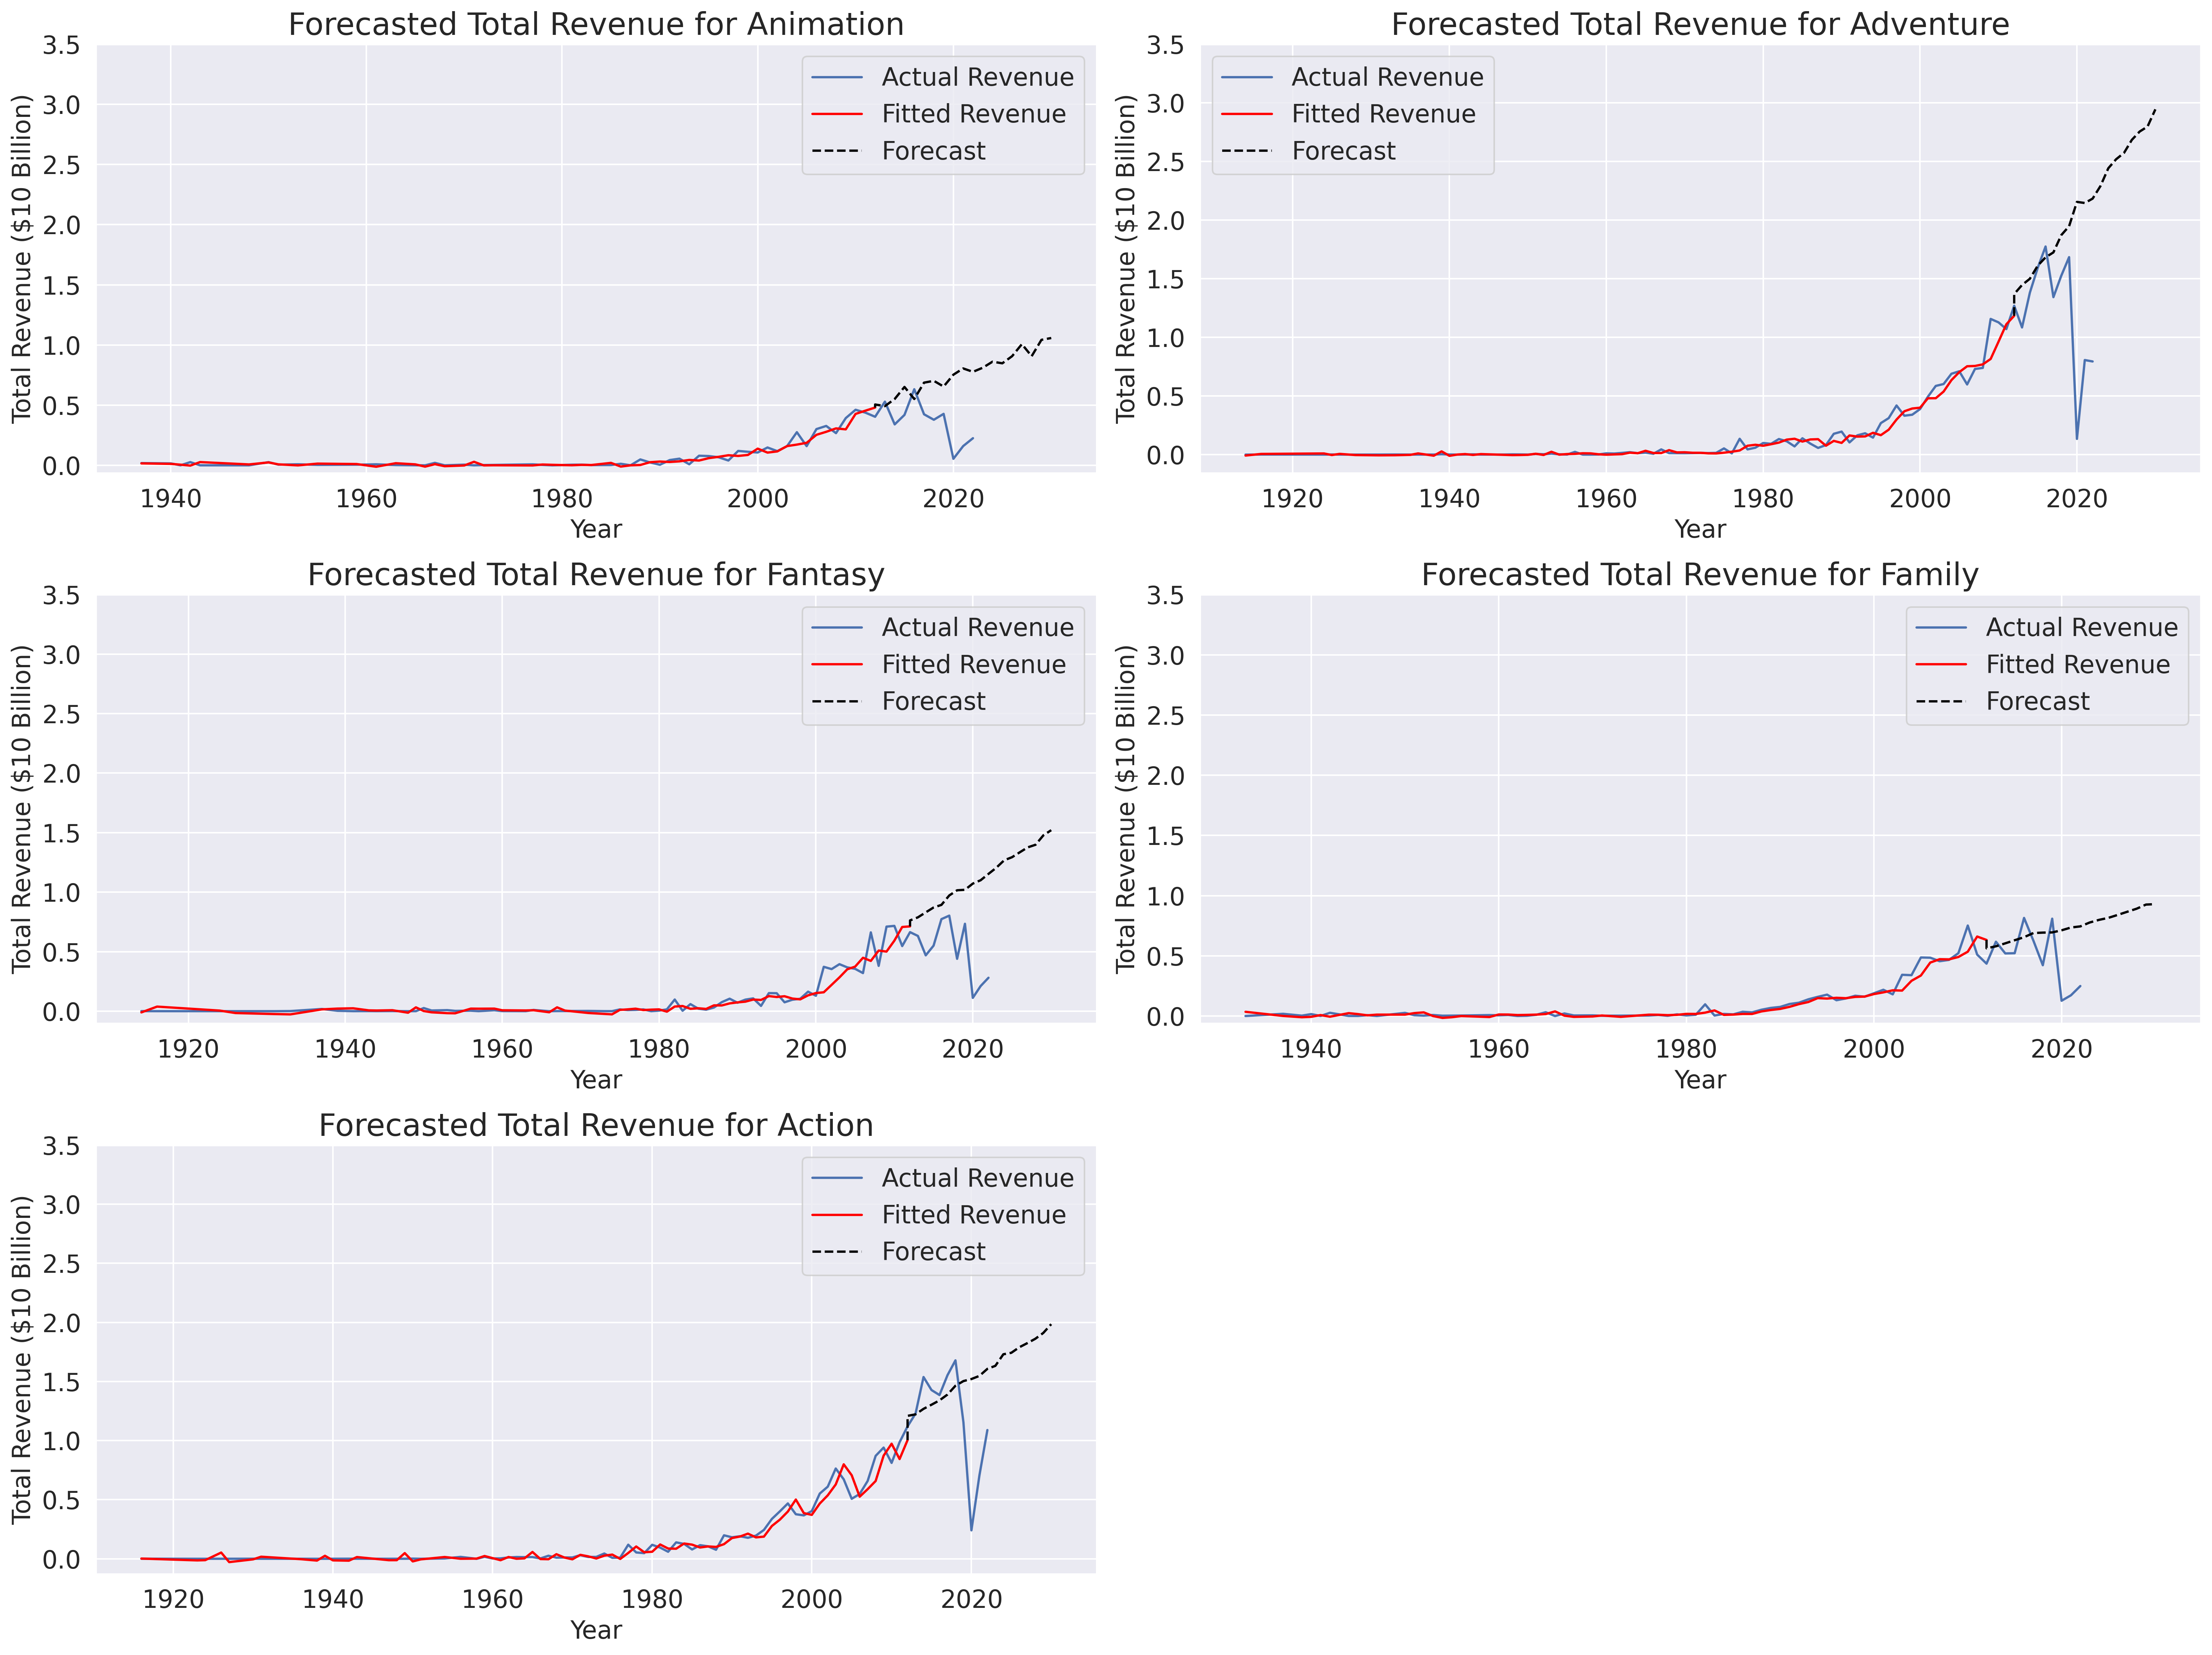

In [44]:
# Holts-Winter forecasting model with additive trend, seasonality on top 5 genres
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes[2][1].set_visible(False)
genres = ['Animation', 'Adventure', 'Fantasy', 'Family', 'Action']
for i, sub_ax in enumerate(axes):
  for j, ax in enumerate(sub_ax):
    if i == 2 and j == 1:
      break
    curr_genre = genres[i*2+j]
    data = genres_df[genres_df['individual_genre'] == curr_genre]
    grouped_data = data.groupby(data['release_date'].dt.year)['adjusted_revenue'].sum().reset_index()
    # Remove 2023 since it does not have full year of data
    grouped_data = grouped_data[grouped_data['release_date'] < 2023]
    train_data = grouped_data[grouped_data['release_date'] <= 2012]
    model = ExponentialSmoothing(train_data['adjusted_revenue'], trend='add', seasonal='add', seasonal_periods=12).fit()
    lookahead = 19
    forecast = model.forecast(lookahead)
    last_obs = int(train_data['release_date'].tail(1))
    grouped_data['adjusted_revenue'] /= 1e10
    grouped_data.plot('release_date','adjusted_revenue', label='Actual Revenue', ax=ax, fontsize=16)
    ax.plot(train_data['release_date'], model.fittedvalues/1e10, color='red', label='Fitted Revenue')
    ax.plot([last_obs] + list(range(last_obs, last_obs+lookahead,1)), np.array([model.fittedvalues.iloc[-1]] + list(forecast.values))/1e10, 'black', label='Forecast', ls='--')
    ax.set_xlabel('Year', fontsize=16)
    ax.set_ylabel('Total Revenue ($10 Billion)', fontsize=16)
    ax.set_ylim(top=3.5)
    ax.legend(fontsize=16)
    ax.set_title(f'Forecasted Total Revenue for {curr_genre}', fontsize=20)
fig.tight_layout(pad=1)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


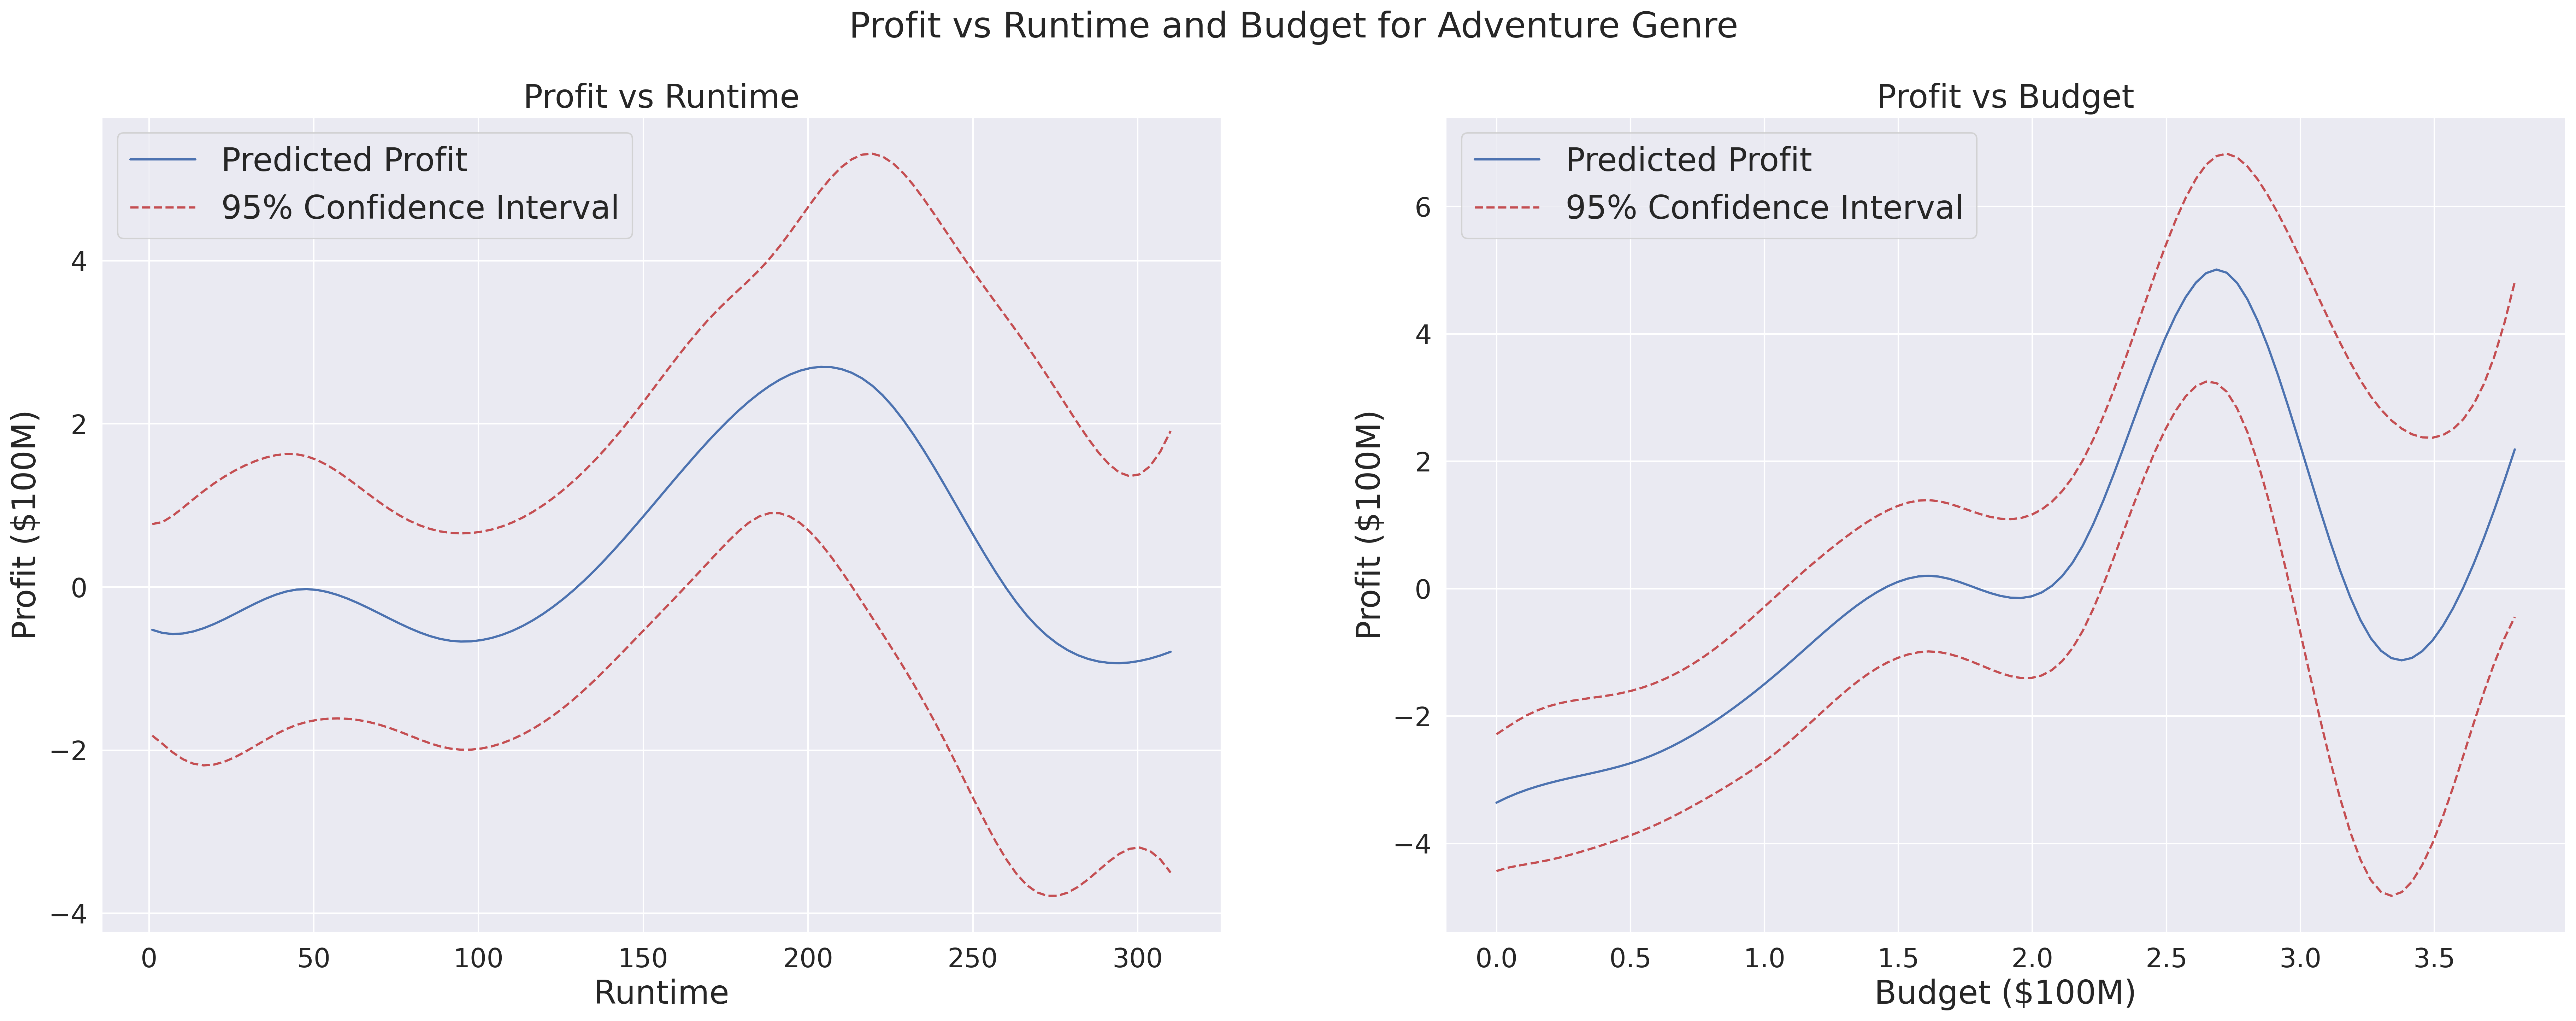

In [51]:
# Fitting Generalized Additive Model
data = genres_df[genres_df['individual_genre'] == 'Fantasy'].copy()
X = data[['runtime', 'adjusted_budget']].values
y = data['adjusted_revenue'] - data['adjusted_budget']
gam = LinearGAM(n_splines=10).gridsearch(X, y)

features = ['Runtime', 'Budget ($100M)']
titles = ['Profit vs Runtime', 'Profit vs Budget']
fig, axs = plt.subplots(1, len(gam.terms)-1, figsize=(30, 10))
for i, term in enumerate(gam.terms):
    if term.isintercept:
      continue
    ax = axs[i]
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    confi /= 1e8
    if i == 1:
      XX[:, term.feature] /= 1e8
    ax.plot(XX[:, term.feature], pdep/1e8, label='Predicted Profit')
    ax.plot(XX[:, term.feature], confi[:, 0], c='r', ls='--', label='95% Confidence Interval')
    ax.plot(XX[:, term.feature], confi[:, 1], c='r', ls='--')
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xlabel(features[i], fontsize=22)
    ax.set_ylabel('Profit ($100M)', fontsize=22)
    ax.set_title(titles[i], fontsize=22)
    ax.legend(fontsize=22)
fig.suptitle('Profit vs Runtime and Budget for Adventure Genre', fontsize=24)
plt.show()

In [52]:
data = genres_df[genres_df['individual_genre'] == 'Fantasy'].copy()
model = smf.ols('adjusted_revenue~runtime + adjusted_budget', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       adjusted_revenue   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     423.7
Date:                Thu, 25 May 2023   Prob (F-statistic):          9.35e-123
Time:                        23:23:43   Log-Likelihood:                -14980.
No. Observations:                 731   AIC:                         2.997e+04
Df Residuals:                     728   BIC:                         2.998e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.111e+08   2.68e+07     -4.146      0.000   -1.64e+08   -5.85e+07
runtime          9.916e+05   2.67e+05      3.717      0.000    4.68e+05    1.52e+06
adjusted_budget     3.1866      0.125     25.550      0.000       2.942       3.431
==============================================================================
Omnibus:                      569.297   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20649.015
Skew:                           3.129   Prob(JB):                         0.00
Kurtosis:                      28.274   Cond. No.                     3.15e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

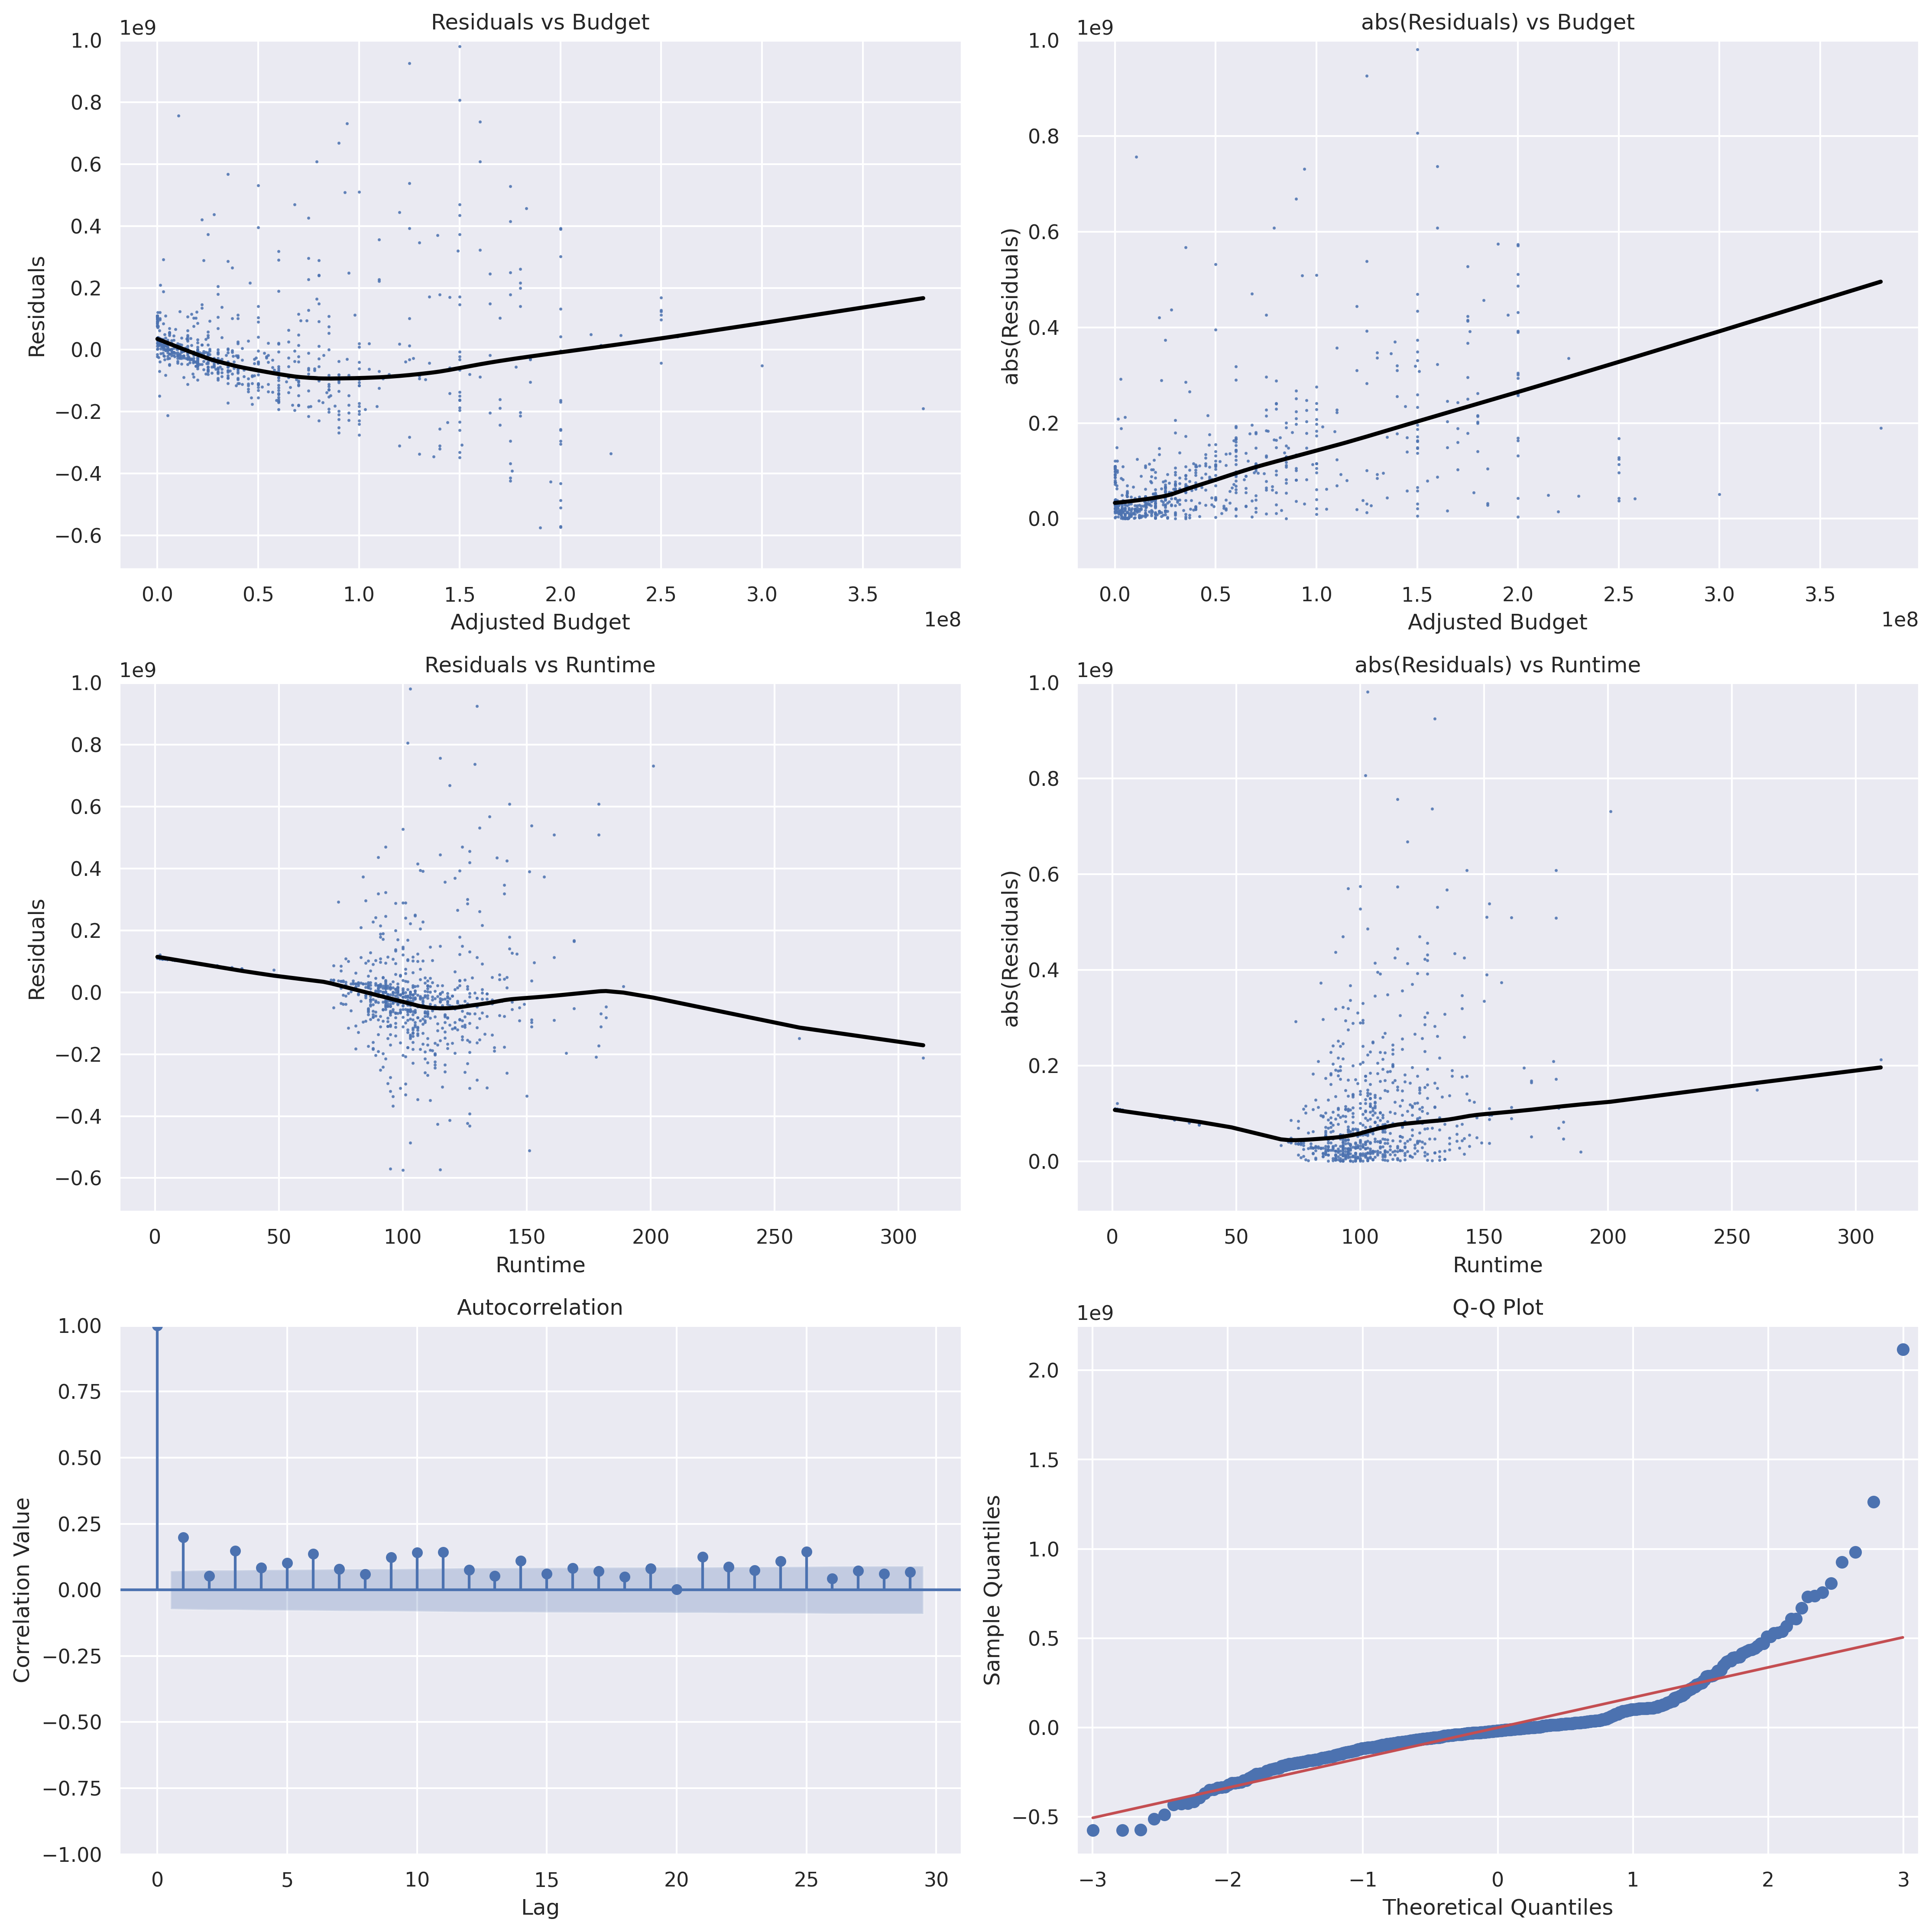

In [53]:
import statsmodels.graphics.tsaplots as tsa
def test_linear_assumptions():
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))
    sns.regplot(x=data['adjusted_budget'], y=model.resid, ax=ax1, lowess=True, \
                line_kws = {'color': 'black'}, \
                scatter_kws = {'s' : 0.5})
    ax1.set_title(f"Residuals vs Budget")
    ax1.set_xlabel("Adjusted Budget")
    ax1.set_ylim(top=1e9)
    ax1.set_ylabel('Residuals')
    sns.regplot(x=data['adjusted_budget'], y=abs(model.resid), ax=ax2, lowess=True, \
    line_kws = {'color': 'black'}, \
    scatter_kws = {'s' : 0.5})
    ax2.set_title(f"abs(Residuals) vs Budget")
    ax2.set_xlabel("Adjusted Budget")
    ax2.set_ylabel('abs(Residuals)')
    ax2.set_ylim(top=1e9)

    sns.regplot(x=data['runtime'], y=model.resid, ax=ax3, lowess=True, \
                line_kws = {'color': 'black'}, \
                scatter_kws = {'s' : 0.5})
    ax3.set_title(f"Residuals vs Runtime")
    ax3.set_xlabel("Runtime")
    ax3.set_ylim(top=1e9)
    ax3.set_ylabel('Residuals')
    sns.regplot(x=data['runtime'], y=abs(model.resid), ax=ax4, lowess=True, \
    line_kws = {'color': 'black'}, \
    scatter_kws = {'s' : 0.5})
    ax4.set_title(f"abs(Residuals) vs Runtime")
    ax4.set_xlabel("Runtime")
    ax4.set_ylabel('abs(Residuals)')
    ax4.set_ylim(top=1e9)

    tsa.plot_acf(model.resid, ax=ax5)
    ax5.set_ylabel('Correlation Value')
    ax5.set_xlabel('Lag')
    sm.qqplot(model.resid, line='r', ax=ax6)
    ax6.set_title("Q-Q Plot")
    plt.tight_layout(pad=1)
    plt.show()
test_linear_assumptions()